This notebook learns both a forward and a reverse model of the suction cup mechanics. Here, we make the following design decisions.

Forward model: from a minimum displacement to aligned, predict the capacitance measurements
Inverse model: from the capacitance measurements, predict the minimum displacement needed to align

- Measurement snapshots, not a steam of data
- Use each time sample at a particular pose as an additional data point
- 

## Inverse Model

In [1]:
%matplotlib widget
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import serial_data_formatter as sdf

The annotations file must be in the format
[file_name_str], [label]

In our case, the label is the displacement necessary to minimally align the suction cup with the box. 

In [2]:
class CapacitanceDataset(Dataset):
    def __init__(self, ground_truth_file, cap_file, cup, box, transform=None, target_transform=None):
        self.ground_truth = pd.read_csv(ground_truth_file)
        self.cup = cup
        self.box = box
        self.displacement_gt = self.calculate_minimum_displacements()
        self.serial_data = sdf.SerialData(cap_file)
        self.cap_data, self.displacements = self.extract_segment_data()
        self.transform = transform
        self.target_transform = target_transform
    
    def calculate_minimum_displacements(self):
        displacements = []
        for idx, row in self.ground_truth.iterrows():
            if row["label"] == "aligned":
                displacements.append((0,0))
                # self.ground_truth.at[idx, 'displacement'] = (0, 0)
            elif row["label"] == "edge_misaligned":
                # Check if x out of bounds
                x_lim = self.box.x_size / 2 - self.cup.diameter / 2
                y_lim = self.box.y_size / 2 - self.cup.diameter / 2
                if abs(row["x"]) > x_lim:
                    # self.ground_truth.at[idx, "displacement"] = (np.sign(row["x"]) * (x_lim - row["x"]), 0)
                    displacements.append((np.sign(row["x"]) * x_lim - row["x"], 0))
                else:
                    # self.ground_truth.at[idx, 'displacement'] = (0, np.sign(row["y"]) * (y_lim - row["y"]))
                    displacements.append((0, np.sign(row["y"]) * y_lim - row["y"]))
            elif row["label"] == "corner_misaligned":
                x_lim = self.box.x_size / 2 - self.cup.diameter / 2
                y_lim = self.box.y_size / 2 - self.cup.diameter / 2
                # self.ground_truth.at[idx, 'displacement'] = (np.sign(row["x"]) * (x_lim - row["x"]), np.sign(row["y"]) * (y_lim - row["y"]))
                displacements.append((np.sign(row["x"]) * x_lim - row["x"], np.sign(row["y"]) * y_lim - row["y"]))
        return np.array(displacements)
    
    def extract_segment_data(self):
        # training data will start during some zero, then go on for some random amount of time
        cap_data = self.serial_data.cap_counts
        cap_data = cap_data - np.mean(cap_data[:self.serial_data.segment_ends[0]], axis=0)
        cap_data = cap_data/10000

        sequence_length = 64

        # ground truth will be zero during no contact, and min displacement during actuation/depression/deactuation
        displacement_gt = np.zeros((len(cap_data), 2))
        # for idx, (start, end) in enumerate(zip(self.serial_data.actuation_starts[::2], self.serial_data.actuation_ends[1::2])):
        for idx, (start, end) in enumerate(zip(self.serial_data.actuation_ends[::2], self.serial_data.actuation_ends[1::2])):
            displacement_gt[start:end] = self.displacement_gt[idx]

        segment_caps = []
        segment_gts = []
        for start, end in zip(self.serial_data.segment_starts[::2], self.serial_data.segment_ends[::2]):
            random_start = np.random.randint(start, end)
            segment_cap = cap_data[random_start:random_start + sequence_length]
            segment_gt = displacement_gt[random_start:random_start + sequence_length]

            if len(segment_cap) != sequence_length:
                continue
            segment_caps.append(segment_cap)
            segment_gts.append(segment_gt)


        return np.array(segment_caps).astype(np.float32), np.array(segment_gts).astype(np.float32)
    
    def extract_average_segment_data(self):
        cap_data = self.serial_data.cap_counts
        cap_data = cap_data - np.mean(cap_data[self.serial_data.segment_ends[0]], axis=0)

        cap_averages = np.array([
            np.mean(cap_data[start:end], axis=0)
            for start, end in zip(self.serial_data.segment_starts, self.serial_data.segment_ends)
        ])[1::2]
        print(cap_averages.shape)
        print(self.displacements.shape)
        return cap_averages.astype(np.float32), self.displacements.astype(np.float32)
    
    def get_segment_time_series(self, idx):
        """Get the time series of the idxth actuated segment"""
        cap_data = self.serial_data.cap_counts
        cap_data = cap_data - np.mean(cap_data[self.serial_data.segment_ends[0]], axis=0)

        start_index = self.serial_data.segment_starts[2*idx + 1] - 200
        end_index = self.serial_data.segment_ends[2*idx + 1] + 200
        return self.serial_data.time[start_index:end_index], cap_data[start_index:end_index]

        

    def __len__(self):
        return len(self.cap_data)
    
    def __getitem__(self, idx):
        return self.cap_data[idx], self.displacements[idx]
        # return self.displacements[idx], self.cap_data[idx]

In [3]:
from offset_generator import Box, SuctionCup

# Build dataset
box = Box(x_size=100, y_size=100)
cup = SuctionCup(diameter=40, lip_to_board_height=6.7, max_actuation=5)
ground_truth_path = "data/translation_gt/251016_1357_randomTranslation_1000x_40mm_gt.csv"
cap_data_path = "data/translation_gt/251016_1357_randomTranslation_1000x_40mm.csv"
cap_dataset = CapacitanceDataset(ground_truth_path, cap_data_path, cup, box, transform=ToTensor())


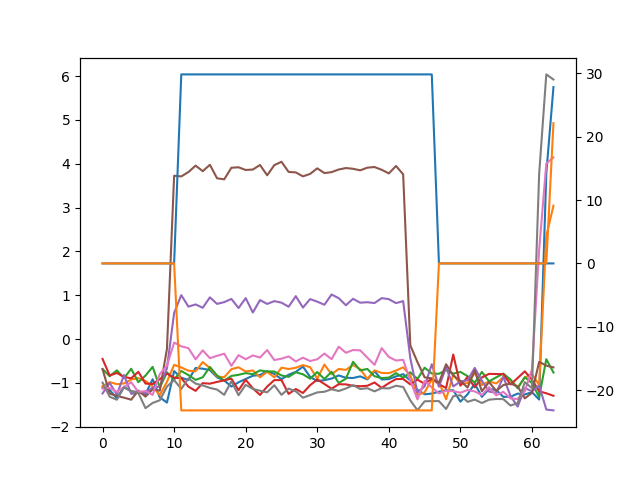

In [4]:
cap, gt = cap_dataset[1]
fig, ax = plt.subplots()
ax.plot(cap)
gt_ax = ax.twinx()
gt_ax.plot(gt)

In [5]:
# Split dataset into train, val, test
indices = np.arange(len(cap_dataset))
splits = [80, 10, 10] # train, val, test
assert sum(splits) == 100
train_end = int(splits[0] / 100 * len(cap_dataset))
val_end = int((splits[0] + splits[1]) / 100 * len(cap_dataset))

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_dataset = Subset(cap_dataset, train_indices)
val_dataset = Subset(cap_dataset, val_indices)
test_dataset = Subset(cap_dataset, test_indices)

# Generate dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
    print(X[0], y[0])
    break

Shape of X: torch.Size([64, 64, 8]), Shape of y: torch.Size([64, 64, 2])
tensor([[-6.0100e-02, -1.2462e-01, -2.6920e-02,  5.2188e-02, -4.1348e-01,
         -6.8812e-01, -3.3280e-01, -2.5977e-01],
        [-7.4400e-02, -1.8224e-02, -3.4842e-01, -9.7112e-02, -3.6058e-01,
         -5.2392e-01, -3.5510e-01, -2.3547e-01],
        [-3.3750e-01, -7.0240e-03, -3.2520e-02, -2.4191e-01, -3.5378e-01,
         -7.6702e-01, -3.4150e-01, -2.7027e-01],
        [-7.8200e-02,  1.9076e-02,  1.0238e-01, -1.4741e-01, -3.9918e-01,
         -5.8802e-01, -5.7710e-01, -1.5527e-01],
        [-2.3800e-01, -1.6562e-01, -2.5892e-01, -3.7811e-01, -4.6878e-01,
         -6.6942e-01, -3.5510e-01, -3.3997e-01],
        [-1.9130e-01, -6.9824e-02, -2.1662e-01, -3.2841e-01, -5.1048e-01,
         -7.9072e-01, -5.1180e-01, -2.7217e-01],
        [-2.6100e-01, -2.1912e-01, -1.6002e-01, -1.2941e-01, -4.1408e-01,
         -6.8492e-01, -4.0360e-01, -3.5987e-01],
        [-1.7020e-01, -2.8062e-01, -1.2772e-01, -1.0571e-01, -4.85

In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class LSTMCorrection(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=2, output_dim=2, bidirectional=False, dropout=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            batch_first = True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional = bidirectional
        )
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)
    
    def forward(self, x, hidden=None):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden


Using cuda device


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred, _ = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (batch % 100 == 0) or (batch == size - 1):
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader)
    return train_loss

def eval_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred, _ = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print("Test Error: \n Avg loss: {:>8f} \n".format(test_loss))
    return test_loss
        
model = LSTMCorrection(num_layers=4)
model = model.to(device)

# loss_fn = nn.MSELoss()
loss_fn = nn.HuberLoss()
num_epochs = 5000
learning_rate = 1e-3
patience = 20

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_without_improvement = 0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss = eval_loop(val_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load("lstm_model.pt", map_location=device))
test_loss = eval_loop(test_dataloader, model, loss_fn)


Epoch 1
-------------------------------
Test Error: 
 Avg loss: 5.743378 

Epoch 2
-------------------------------
Test Error: 
 Avg loss: 5.046982 

Epoch 3
-------------------------------
Test Error: 
 Avg loss: 4.297109 

Epoch 4
-------------------------------
Test Error: 
 Avg loss: 3.847199 

Epoch 5
-------------------------------
Test Error: 
 Avg loss: 3.370276 

Epoch 6
-------------------------------
Test Error: 
 Avg loss: 3.019141 

Epoch 7
-------------------------------
Test Error: 
 Avg loss: 2.756705 

Epoch 8
-------------------------------
Test Error: 
 Avg loss: 2.497811 

Epoch 9
-------------------------------
Test Error: 
 Avg loss: 2.234635 

Epoch 10
-------------------------------
Test Error: 
 Avg loss: 2.084257 

Epoch 11
-------------------------------
Test Error: 
 Avg loss: 1.927643 

Epoch 12
-------------------------------
Test Error: 
 Avg loss: 1.858568 

Epoch 13
-------------------------------
Test Error: 
 Avg loss: 2.102648 

Epoch 14
------------

Text(0.5, 1.0, 'First 100 Seconds of Test Set Inference\nLSTM')

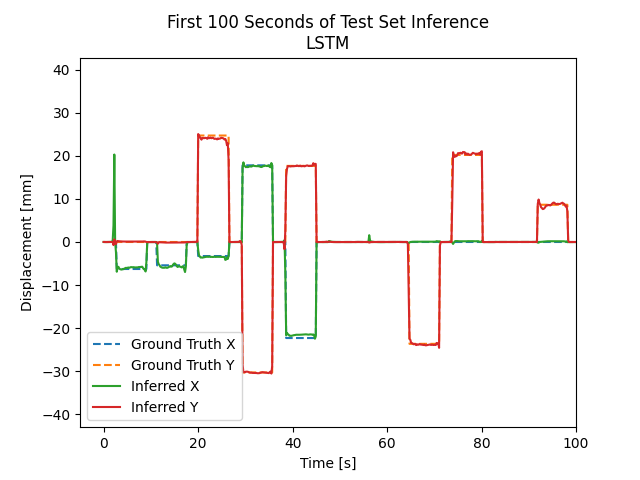

In [41]:
# Generate inference on entire continuous test set
serial_data = cap_dataset.serial_data
gt_start_idx = test_indices[0]

data_start_idx = serial_data.segment_starts[gt_start_idx]
cap_data = serial_data.cap_counts
cap_data = cap_data - np.mean(cap_data[:serial_data.segment_ends[0]], axis=0)
cap_data = cap_data/10000
cap_data = cap_data[data_start_idx:] 
cap_data = np.ascontiguousarray(cap_data)

timestamps = serial_data.time[data_start_idx:]

displacements = cap_dataset.displacement_gt
displacement_gt = np.zeros((len(serial_data.cap_counts), 2))
for idx, (start, end) in enumerate(zip(serial_data.actuation_ends[::2], serial_data.actuation_ends[1::2])):
    displacement_gt[start:end] = displacements[idx]
displacement_gt = displacement_gt[data_start_idx:]

torch.backends.cudnn.enabled = False
model = model.to("cpu")
# model = model.to(device)
model.eval()
with torch.no_grad():
    # tX = torch.tensor(cap_data, dtype=torch.float32).to(device)
    tX = torch.tensor(cap_data, dtype=torch.float32).to("cpu")
    tX = tX.clone().contiguous().unsqueeze(0)
    pred, _ = model(tX)
    pred = pred.cpu().detach().numpy()[0]

# fig, cap_ax = plt.subplots()
# cap_ax.plot(timestamps, cap_data)
# gt_ax = cap_ax.twinx()
# gt_ax.plot(timestamps, displacement_gt)
# gt_ax.plot(timestamps, pred)

fig, ax = plt.subplots()
ax.plot(timestamps - timestamps[0], displacement_gt, "--")
ax.plot(timestamps - timestamps[0], pred)
ax.set_xlim([-5, 100])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Displacement [mm]")
ax.legend(["Ground Truth X", "Ground Truth Y", "Inferred X", "Inferred Y"])
ax.set_title("First 100 Seconds of Test Set Inference\nLSTM")

In [19]:
# Randomly sample time series for visualization
idx_samples = np.random.randint(0, len(cap_data), 1000)

### Prediction vs Ground Truth
There is a minimum displacement correction needed to realign the suction cup to the box. The ground truth correction is compared to the predicted correction. Both the x and y coordinates can be inspected.

40


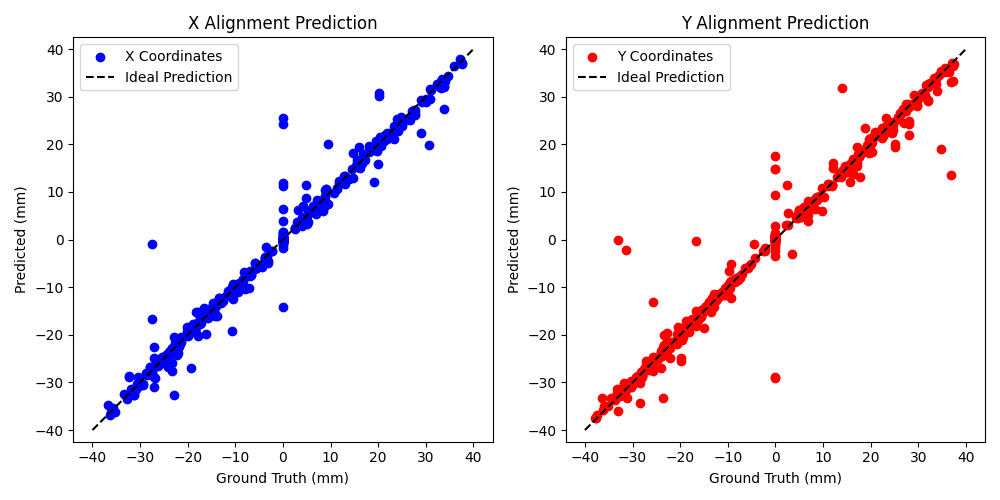

In [20]:
gt_xs = displacement_gt[idx_samples, 0]
gt_ys = displacement_gt[idx_samples, 1]
pred_xs = pred[idx_samples, 0]
pred_ys = pred[idx_samples, 1]

fig, axs = plt.subplots(1, 2, figsize=(10,5))
bound = cup.diameter
print(bound)
axs[0].scatter(gt_xs, pred_xs, color="b", label="X Coordinates")
axs[0].plot([-bound, bound], [-bound, bound], 'k--', label="Ideal Prediction")
axs[0].set_aspect('equal', 'datalim')
axs[0].set_title('X Alignment Prediction')
axs[0].set_xlabel('Ground Truth (mm)')
axs[0].set_ylabel('Predicted (mm)')
axs[0].legend()

axs[1].scatter(gt_ys, pred_ys, color="r", label="Y Coordinates")
axs[1].plot([-bound, bound], [-bound, bound], 'k--', label="Ideal Prediction")
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title('Y Alignment Prediction')
axs[1].set_xlabel('Ground Truth (mm)')
axs[1].set_ylabel('Predicted (mm)')
axs[1].legend()

plt.tight_layout()

### Error Histograms
For the x and y components, we plot the error in x and the error in y on a histogram.

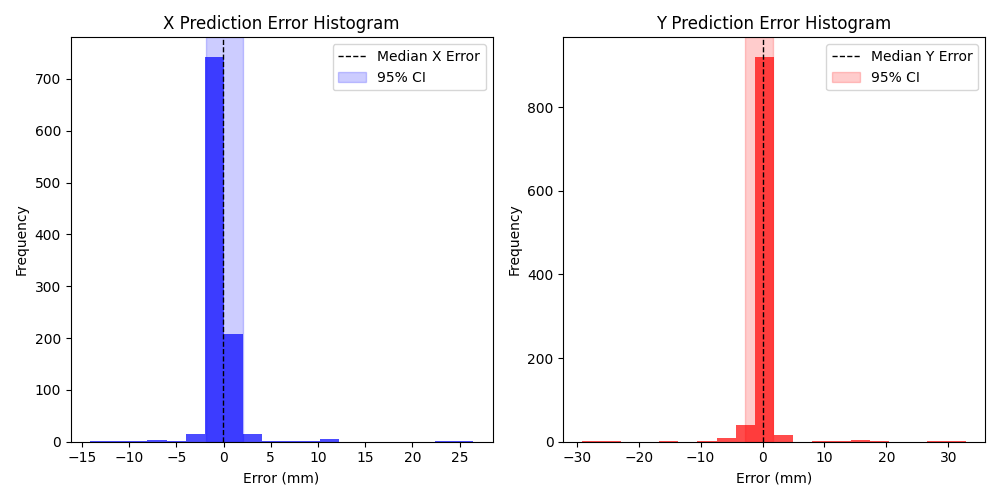

In [21]:
error_x = np.array(pred_xs) - np.array(gt_xs)
error_y = np.array(pred_ys) - np.array(gt_ys)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].hist(error_x, bins=20, color='b', alpha=0.7)
axs[0].set_title('X Prediction Error Histogram')
axs[0].set_xlabel('Error (mm)')
axs[0].set_ylabel('Frequency')
axs[0].axvline(x=np.median(error_x), color='k', linestyle='dashed', linewidth=1, label="Median X Error")
axs[0].axvspan(xmin=np.quantile(error_x, 0.025), xmax=np.quantile(error_x, 0.975), color='blue', alpha=0.2, label='95% CI')
axs[0].legend()

axs[1].hist(error_y, bins=20, color='r', alpha=0.7)
axs[1].set_title('Y Prediction Error Histogram')
axs[1].set_xlabel('Error (mm)')
axs[1].set_ylabel('Frequency')
axs[1].axvline(x=np.median(error_y), color='k', linestyle='dashed', linewidth=1, label="Median Y Error")
axs[1].axvspan(xmin=np.quantile(error_y, 0.025), xmax=np.quantile(error_y, 0.975), color='red', alpha=0.2, label='95% CI')
axs[1].legend()
plt.tight_layout()

(-1.0, 20.0)

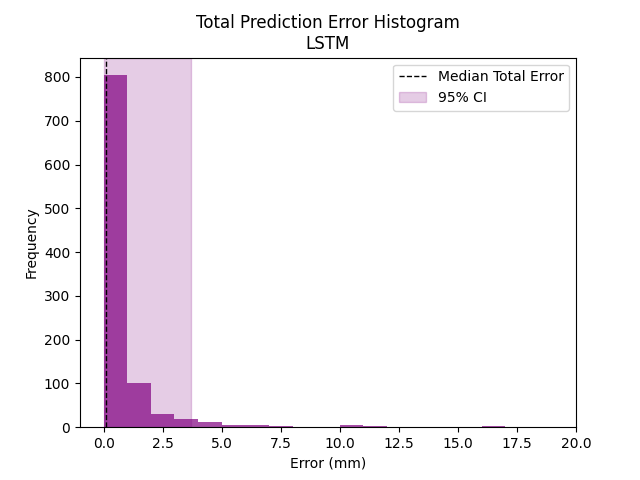

In [29]:
fig, ax = plt.subplots()
error = np.sqrt(error_x**2 + error_y**2)
ax.hist(error, bins=np.arange(20), color='purple', alpha=0.7)
ax.set_title('Total Prediction Error Histogram\nLSTM')
ax.set_xlabel('Error (mm)')
ax.set_ylabel('Frequency')
ax.axvline(x=np.median(error), color='k', linestyle='dashed', linewidth=1, label="Median Total Error")
ax.axvspan(xmin=np.quantile(error, 0), xmax=np.quantile(error, 0.95), color='purple', alpha=0.2, label='95% CI')
ax.legend()
ax.set_xlim(-1, 20)

### Predition Displacement
The prediction outputs an expected necessary position vector for realignment. We compare this to the ground truth requirement and plot the difference between the two. The blue dots represent ground truth, the red dots the predictions, and the black connecting lines represent the error between the two. 

Text(0, 0.5, 'Y Displacement (mm)')

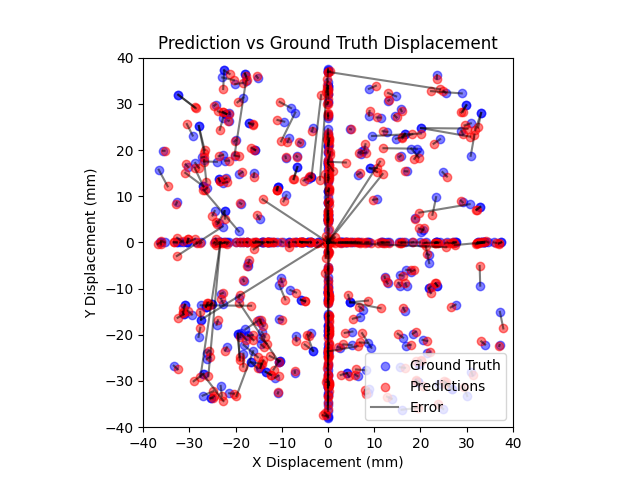

In [23]:
fig, ax = plt.subplots()
ax.scatter(gt_xs, gt_ys, label="Ground Truth", color='blue', alpha=0.5)
ax.scatter(pred_xs, pred_ys, label="Predictions", color='red', alpha=0.5)
ax.plot(np.vstack([gt_xs, pred_xs]), np.vstack([gt_ys, pred_ys]), 'k', alpha=0.5, label="Error")
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_aspect("equal")
ax.legend(["Ground Truth", "Predictions", "Error"])
ax.set_title("Prediction vs Ground Truth Displacement")
ax.set_xlabel("X Displacement (mm)")
ax.set_ylabel("Y Displacement (mm)")
    

### Losses over Epochs
Plotting the training and validation loss, as well as their ratio.

Text(0.5, 1.0, 'Training and Validation Losses')

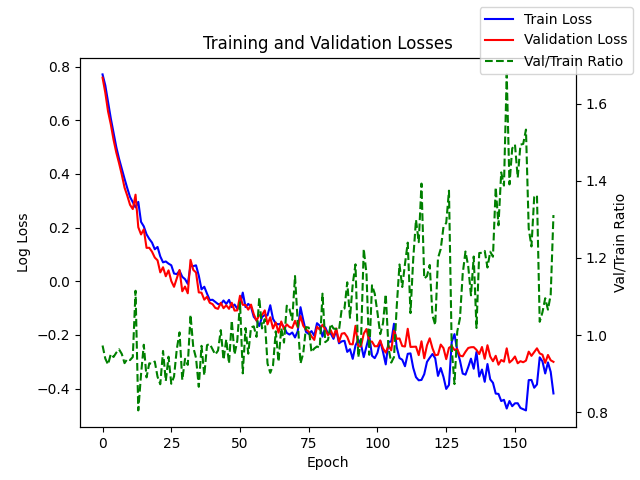

In [24]:
fig, ax = plt.subplots()
ratio_ax = ax.twinx()
ax.plot(np.log10(train_losses), 'b-', label="Train Loss")
ax.plot(np.log10(val_losses), 'r-', label="Validation Loss")
ratio_ax.plot(np.array(val_losses) / np.array(train_losses), 'g--', label="Val/Train Ratio")
ax.set_xlabel("Epoch")
ax.set_ylabel("Log Loss")
ratio_ax.set_ylabel("Val/Train Ratio")
fig.legend()
ax.set_title("Training and Validation Losses")